

#Importing

In [25]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    #!pip install --upgrade typeguard==4.0.1 inflect
    #!pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 134.3 MB/s eta 0:00:00


#Main


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('sample_data/MSFT.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/7/2016,59.779999,60.520000,59.779999,60.419998,55.902321,31664800
1,11/8/2016,60.549999,60.779999,60.150002,60.470001,55.948589,22935400
2,11/9/2016,60.000000,60.590000,59.200001,60.169998,55.671009,49632500
3,11/10/2016,60.480000,60.490002,57.630001,58.700001,54.310928,57822400
4,11/11/2016,58.230000,59.119999,58.009998,59.020000,54.607002,38767800


In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df = df.drop(columns=["Adj Close"])
feature_columns = ["Open", "High", "Low", "Close", "Volume"]

In [33]:
df.tail()

,Date,Open,High,Low,Close,Volume
1254,2021-11-01,331.359985,331.489990,326.369995,329.369995,27073200
1255,2021-11-02,330.309998,333.450012,330.000000,333.130005,26487100
1256,2021-11-03,333.899994,334.899994,330.649994,334.000000,21500100
1257,2021-11-04,332.890015,336.540009,329.510010,336.440002,23992200
1258,2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000


In [7]:
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_columns] = scaler.fit_transform(df_scaled[feature_columns])

In [8]:
import tensorflow as tf
from tensorflow import keras
import sklearn

###Creating sequences

In [9]:
def make_sequences(dataframe, feature_columns, seq_length):
  values = dataframe[feature_columns].values
  X = []
  y = []
  for i in range(len(values) - seq_length):
    X.append(values[i:i + seq_length])
    y.append(values[i + seq_length])
  X = np.array(X)
  y = np.array(y)
  return X, y

In [11]:
seq_length = 30
X, y = make_sequences(df_scaled, feature_columns, seq_length)

print(X.shape)
print(y.shape)

(1229, 30, 5)
(1229, 5)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [19]:
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense

model_gru = Sequential([
    GRU(64, input_shape=(seq_length, len(feature_columns))),
    Dense(len(feature_columns))
])

model_gru.compile(optimizer="adam", loss="mse")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,957 (54.52 KB)

 Trainable params: 13,957 (54.52 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping_gru = EarlyStopping(patience=5, restore_best_weights=True)

In [22]:
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping_gru]
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0428 - val_loss: 0.0217
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 9.9277e-04
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 9.7399e-04
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014

In [23]:
model_gru.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2469e-04 


0.0009739878005348146

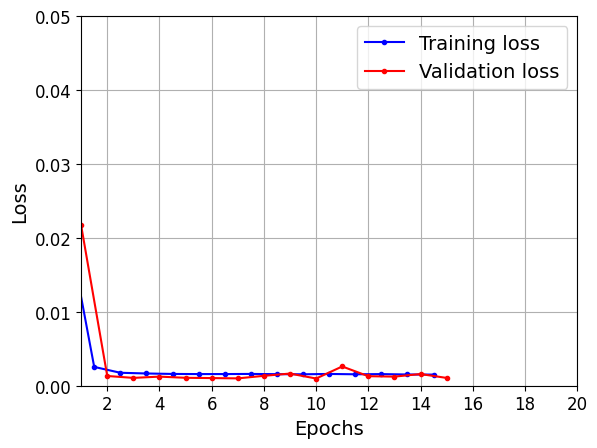

In [26]:
plot_learning_curves(history_gru.history["loss"], history_gru.history["val_loss"])
plt.show()

In [29]:
gru_val_loss = min(history_gru.history["val_loss"])
print("GRU best val_loss:", gru_val_loss)
print("Accuracy: ", 1 - gru_val_loss)

GRU best val_loss: 0.0009739878005348146
Accuracy:  0.9990260121994652


###Predict the values of sequence_len days and return a dataframe containing the predicted dates. First I get the most recent n_day values from my dataframe, these most recent 30 days will be used to predict the next day, at which point the window will shift. I also make sure to reshape the values such that my model can make predictions on them. I then inverse transform the values to match real world data since the processed values are normalized. Finally I return the predicted sequence as a dataset.

In [30]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay

def predict_future(model, df_scaled, scaler, feature_columns, seq_length, start_date, n_days):
    df_sorted = df_scaled.sort_values("Date").reset_index(drop=True)
    window_values = df_sorted[feature_columns].tail(seq_length).values
    current_input = window_values.reshape(1, seq_length, len(feature_columns))
    future_preds = []
    for _ in range(n_days):
        pred = model.predict(current_input, verbose=0)
        future_preds.append(pred[0])
        current_input = np.append(current_input[:, 1:, :], pred.reshape(1, 1, len(feature_columns)), axis=1)
    future_preds = np.array(future_preds)
    future_real = scaler.inverse_transform(future_preds)
    start_date = pd.to_datetime(start_date)
    dates = []
    d = start_date
    while len(dates) < n_days:
        if d.weekday() < 5:
            dates.append(d)
        d = d + pd.Timedelta(days=1)
    future_df = pd.DataFrame(future_real, columns=feature_columns)
    future_df.insert(0, "Date", dates)
    return future_df


In [31]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]

In [32]:

future_gru = predict_future(
    model_gru,
    df_scaled,
    scaler,
    feature_columns,
    seq_length,
    start_date="2021-11-08",
    n_days=10
)

print(future_gru)

        Date        Open        High         Low       Close      Volume
0 2021-11-08  330.548523  333.829437  325.620026  329.477997  20019774.0
1 2021-11-09  330.135803  331.575989  324.426300  329.122406  17962686.0
2 2021-11-10  328.783844  329.855133  323.048920  327.648071  16593351.0
3 2021-11-11  327.231384  328.321625  321.517548  326.027863  15569877.0
4 2021-11-12  325.674896  326.878937  320.036835  324.417389  14781834.0
5 2021-11-15  324.157196  325.509521  318.640778  322.886780  14159076.0
6 2021-11-16  322.692413  324.202179  317.328888  321.448547  13659130.0
7 2021-11-17  321.288025  322.948059  316.090332  320.098724  13254948.0
8 2021-11-18  319.947388  321.742584  314.913879  318.829010  12927974.0
9 2021-11-19  318.670319  320.581787  313.790802  317.631378  12664459.0


#Importing microsoft's historical stock data between 2021-11-08 and 2021-11-19

In [34]:
df_true = pd.read_csv('sample_data/MSFT_FUTURE.csv')

In [35]:
df_true["Date"] = pd.to_datetime(df_true["Date"])

In [36]:
df_true = df_true.drop(df_true.index[-2:])
df_true

,Date,Open,High,Low,Close,Volume
0,2021-11-08,325.77,326.11,323.01,325.47,20897000.0
1,2021-11-09,325.58,327.14,323.09,324.47,21307369.0
2,2021-11-10,323.13,323.19,318.64,319.49,25500939.0
3,2021-11-11,319.93,322.36,319.21,321.07,16849840.0
4,2021-11-12,322.51,325.70,322.38,325.21,23831051.0
5,2021-11-15,326.00,326.33,322.62,324.58,16723010.0
6,2021-11-16,324.21,329.02,324.04,327.90,20886830.0
7,2021-11-17,327.95,331.10,327.04,328.13,19053381.0
8,2021-11-18,327.22,331.35,326.19,330.21,22463529.0
9,2021-11-19,331.53,333.91,331.11,331.99,21963400.0


In [37]:
def calc_mse(feature_cols, df_true, df_pred):
    df_merged = pd.merge(df_true, df_pred, on="Date", suffixes=("_true", "_pred"))
    mse = {}
    for col in feature_cols:
      y_true = df_merged[f"{col}_true"].values
      y_pred = df_merged[f"{col}_pred"].values
      mse = np.mean((y_true - y_pred) ** 2)
      print(col, "MSE:", mse)

In [38]:
calc_mse(feature_columns, df_true, future_gru)

Open MSE: 40.72255603394939
High MSE: 52.09049902144413
Low MSE: 64.67256837890223
Close MSE: 57.415825878910745
Volume MSE: 44466053037911.8


In [39]:
import matplotlib.pyplot as plt

def plot_pred_vs_true(df_true, df_pred, feature_cols):
    df = pd.merge(df_true, df_pred, on="Date", suffixes=("_true", "_pred"))
    dates = df["Date"]
    for col in feature_cols:
        plt.figure(figsize=(5, 5))
        plt.plot(dates, df[f"{col}_true"], label="True")
        plt.plot(dates, df[f"{col}_pred"], label="Predicted")
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()


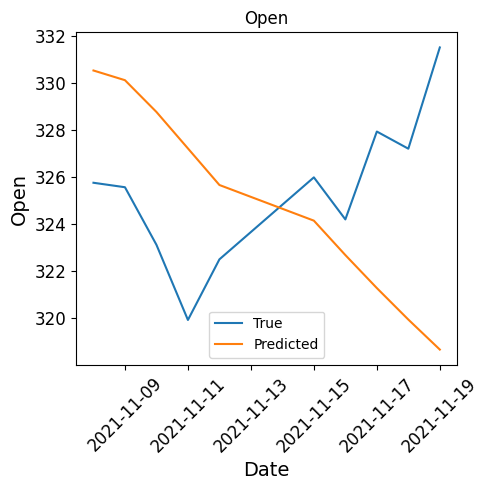

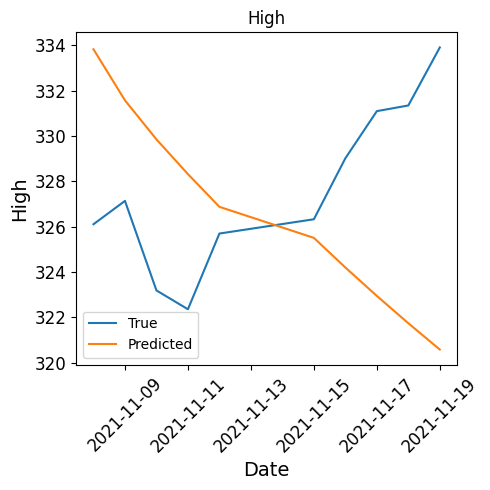

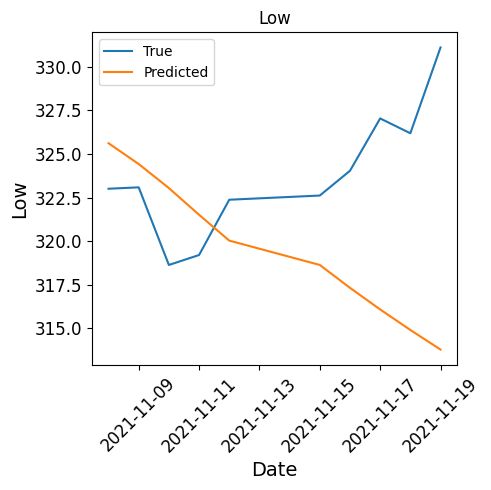

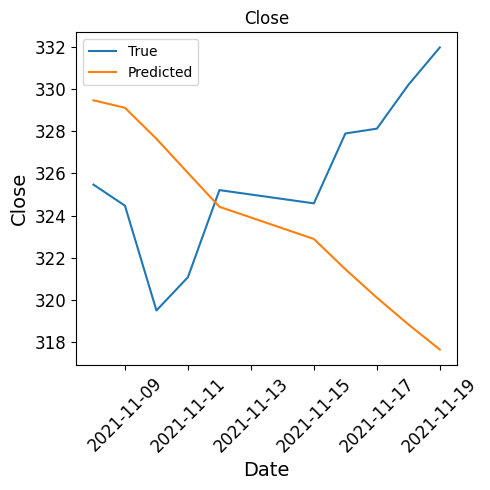

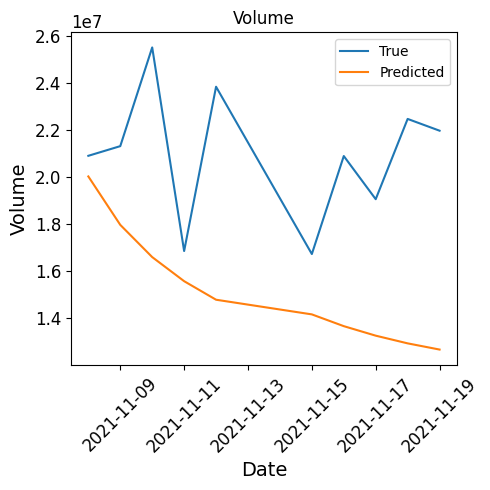

In [40]:
plot_pred_vs_true(df_true, future_gru, feature_columns)

#Trying different sequence lengths on the model

In [41]:
seq_length = 10

In [43]:
second_model_gru = Sequential([
    GRU(64, input_shape=(seq_length, len(feature_columns))),
    Dense(len(feature_columns))
])

second_model_gru.compile(optimizer="adam", loss="mse")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
early_stopping_second_gru = EarlyStopping(patience=5, restore_best_weights=True)

history_second_gru = second_model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[early_stopping_second_gru]
)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0543 - val_loss: 0.0161
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 12/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_l

In [49]:
smaller_sequence = second_model_gru.evaluate(X_test, y_test)
print(smaller_sequence)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.8336e-04 
0.0012871773215010762


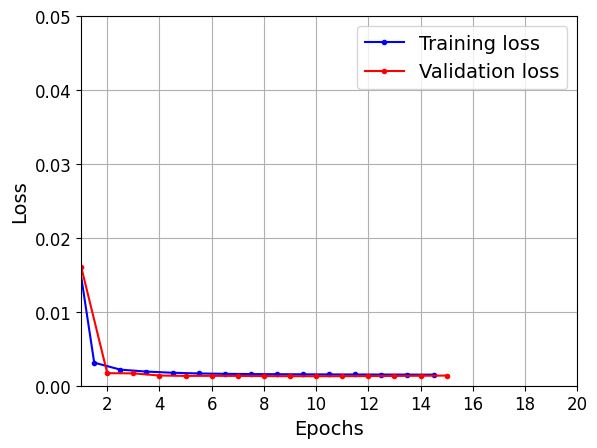

In [46]:
plot_learning_curves(history_second_gru.history["loss"], history_second_gru.history["val_loss"])
plt.show()


In [47]:
second_future_gru = predict_future(
    second_model_gru,
    df_scaled,
    scaler,
    feature_columns,
    seq_length,
    start_date="2021-11-08",
    n_days=10
)

print(future_gru)

        Date        Open        High         Low       Close      Volume
0 2021-11-08  330.548523  333.829437  325.620026  329.477997  20019774.0
1 2021-11-09  330.135803  331.575989  324.426300  329.122406  17962686.0
2 2021-11-10  328.783844  329.855133  323.048920  327.648071  16593351.0
3 2021-11-11  327.231384  328.321625  321.517548  326.027863  15569877.0
4 2021-11-12  325.674896  326.878937  320.036835  324.417389  14781834.0
5 2021-11-15  324.157196  325.509521  318.640778  322.886780  14159076.0
6 2021-11-16  322.692413  324.202179  317.328888  321.448547  13659130.0
7 2021-11-17  321.288025  322.948059  316.090332  320.098724  13254948.0
8 2021-11-18  319.947388  321.742584  314.913879  318.829010  12927974.0
9 2021-11-19  318.670319  320.581787  313.790802  317.631378  12664459.0


In [48]:
calc_mse(feature_columns, df_true, second_future_gru)

Open MSE: 275.77507243359355
High MSE: 403.0482693746386
Low MSE: 541.1699815682277
Close MSE: 621.6132050412593
Volume MSE: 7108802860593.7


#Summary

Using a larger sequence length(30) is roughly 1.32x (1.32) more accurate then using smaller sequences. And that makes sense since the model has a much larger window to look at. And it goes without saying that the simple rnn was the least accurate while the GRU was the most accurate model.

In [50]:
print(smaller_sequence / 0.0009739878005348146)

1.3215538436870462
